# STOCK/CRPYTO PRICE PREDICTION MODEL

## The following code is an example on how to use simple data analysis tolls in order to set up a simple strategy for long and short term financial trading

### We will make use of the programing language python (3.x) which suits nicely for data anlysis

## Required modules:
- numpy: the code is designed to be vectorized such that the numpy module can be used and calculations performed fast
- pandas: module for illustrative data frames
- yfinance: api module provided by yahoo finance to get current and previous asset prices
- matplotlib: (sub)module(s) for plots
- scipy: (sub)module for further analysis
- datetime: (optional)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.signal import argrelextrema
import datetime

## Define functions: 

In [2]:
def download_data(ticker, timestamp='Close', *args, **kwargs):
    '''
    Function to download data from yahoo finance. 
    Inputs: 
        - ticker: asset of interest. Name has to be concise with yahoo finance. 
        - timestamp: datetime of evaluation.
            default: Close, i.e. closing prices of asset
            It is important to note, even if today's market is open (and not yet closed), 
            the last value in 'Close' will be the current value of the asset by the time of downloading.
        - additional arguments and keywords, 
            i.e. *args, **kwargs that will be passed to the yfinance function for downloading
    Outputs:
        - pandas.core.series.Series, i.e. prices of the asset at the specified timestamp.
    '''
    return yf.download(ticker, *args, **kwargs)[timestamp]

def calc_EMA(data, average_sample):
    '''
    Function to calculate the exponential moving average
    Inputs:
        - average_sample: number of days to average
    Outputs:
        - pandas.core.series.Series, i.e. ema prices.
    '''
    return data.ewm(span=average_sample, adjust=False).mean()
 
def price_model(data, values_of_interest=(12, 26, 9), buy_delay=1, grad_return=True):
    '''
    Function to set up the price model. The idea is to locate the inflection points of the difference of
    "moving average converging diverging (MACD)" and "Signal Line (Signal_Line)". These indicate local up and down
    trends. The actual buy and sell prices are therefore the next day, i.e. buy_delay
    Inputs: 
        - data: asset prices
        - values_of_interest: days to calculate the MACD (first two values) and Signal Line (last value). 
            default: 12, 26, 9
        - buy_delay: buy and sell dates
            default: 1
        - grad_return: return the "gradient" of the model, i.e. the model itself
            default: True
    Outputs:
        - local_min: Buy prices
        - local_max: Sell prices
        - grad: "gradient" of the model (optionally)
    '''
    MACD = calc_EMA(data, values_of_interest[0]) - calc_EMA(data, values_of_interest[1])
    Signal_Line = calc_EMA(MACD, values_of_interest[2])
    grad = np.gradient(MACD - Signal_Line)
    local_min = argrelextrema(grad, np.less)[0]
    local_max = argrelextrema(grad, np.greater)[0]
    try:
        if local_max[0] < local_min[0]:
            local_max = local_max[1:]    
    except IndexError:
        pass
        #case where one has one sell data without a buy data
    
    if grad_return:
        return local_min + buy_delay, local_max + buy_delay, grad
    else:
        return local_min + buy_delay, local_max + buy_delay

def evaluate_price_model(data, locs_and_grad, entry_money=1000, fees=(1.005, .995), tax=.75, df_return=True, visualize=False, *args, **kwargs):
    '''
    Function to evaluate the price model predictions
    Inputs:
        - data: price data of asset
        - locs: buy and sell locations, i.e. return from from function price_model()
        - entry_money: initial investment
            default = 100
        - fees: fee for buying and selling prices, i.e. buy asset at broker for slightly higher price than actual asset prices, vice versa for sells
            default = (1.005, .995), i.e. .5% higher buy price and .5% lower sell price
        - tax: german tay payments for annual wins > 800€
            default = .75, i.e. 25%
        - df_return: return model evaluation as pandas DataFrame
            default = True
    Outputs:
        - net_income: Net Income/win after entry_money (and possibly tax) subtracted
        - df_return: model evaluation as pandas DataFrame
    '''
    try:
        ticker=kwargs['ticker']
    except KeyError:
        ticker='Unknown'
    print_opening(ticker=ticker, start_date = data.index[0].strftime('%D'), \
                  end_date = data.index[-1].strftime('%D'), \
                  initial_investment = entry_money)
    if locs_and_grad is None:
        return
    buy_locs, sell_locs = locs_and_grad[0:2]
    if buy_locs.shape[0] > sell_locs.shape[0]:
        print('[INFO]: There is currently an open position to be sold in the future.')
    buy_prices = data[buy_locs]
    buy_dates = data.index.values[buy_locs]
    sell_prices = data[sell_locs]
    sell_dates = data.index.values[sell_locs]
    #Include fees
    buy_prices *= fees[0]
    sell_prices *= fees[1]
    #Initialize arrays
    number_of_calls = sell_prices.shape[0]
    if buy_prices.shape > sell_prices.shape:
        #must use to_numpy() since the dates are still stored in prices as names 
        #-> pandas devides same dates, obviously buy and sell dates differ, 
        #hence pandas would return NaN all the time
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()[:-1]
    else:
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()
    trade_rewards = entry_money * np.cumprod(ratios)
    #Calculate trade wins
    trade_wins = np.diff(trade_rewards)
    #Insert first win
    try:
        trade_wins = np.insert(trade_wins, 0, trade_rewards[0] - entry_money)
    except IndexError:
        #case where one has one buy but not yet selled.
        pass
    #Evaluate Calls
    good_calls = np.where(trade_wins > 0)
    bad_calls = np.where(trade_wins < 0)
    tax_pays = trade_wins[good_calls] * tax
    try:
        efficiency = good_calls[0].shape[0] / number_of_calls
    except ZeroDivisionError:
        efficiency = np.nan
    #net_income = trade_rewards[-1] - np.sum(tax_pays) - entry_money
    #That is the same?!
    if np.sum(trade_wins) > 800:
        print('[INFO]: {:.2f} tax was paid.'.format(np.sum(trade_wins) * (1 - tax)))
        #Pay taxes every time ? 
        net_income = np.sum(trade_wins) - np.sum(tax_pays)
        #Else pay taxes after last sell
        net_income = (trade_rewards[-1] - entry_money) * tax
    else:
        print('[INFO]: No tax paid. (win < 800)!')
        net_income = np.sum(trade_wins)
    #create final DataFrame
    #be aware that buy_dates can be 1 entry longer then sell dates!
    if buy_dates.shape[0] > sell_dates.shape[0]:
        if sell_dates.shape[0] > 0:
            print('[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.')
            sell_dates = np.append(sell_dates, sell_dates[-1])
        else:
            print('[INFO]: First entry of "Sell Dates" will be first entry of "Buy Dates".')
            sell_dates = buy_dates[0]
        sell_prices.loc[pd.Timestamp.max] = np.nan
        trade_rewards = np.append(trade_rewards, np.nan)
        trade_wins = np.append(trade_wins, np.nan)
    final_df = pd.DataFrame(data = {'Buy Dates': buy_dates, 'Sell Dates': sell_dates, \
                                    'Buy Prices': buy_prices.to_numpy(), 'Sell Prices': sell_prices.to_numpy(), \
                                    'Trade Reward': trade_rewards, 'Trade Win': trade_wins})
    print('*'*80)    
    if efficiency == 1:
        print('[SUMMARY]: Perfect Model --> Zero Bad Calls')
    else:
        print('[SUMMARY]: Efficiency: {:.2%}'.format(efficiency))
    print('[SUMMARY]: NET WIN: {:.2f}'.format(net_income))
    print('*'*80)
    print('FINAL BUY/SELL HISTORY:')
    print(final_df)
    print('*'*80)
    if visualize:
        print('[INFO]: "visualize" is active --> no returns for this function')
        try:
            grad = locs_and_grad[2]
            plot_model(final_df, data, grad, (buy_locs, sell_locs))
        except IndexError:
            print('[ERROR]: plot_model() not possible. Input "grad" is not passed/available!')
    else:
        if df_return:
            return net_income, final_df
        else:
            return net_income
    
def plot_model(model, data, grad, locs):
    '''
    Function to plot a model.
    Inputs:
        - model: price model
        - data: asset prices
        - grad: "gradient" of price model
        - locs: "locations" of price model
    '''
    plt.figure(figsize=(16, 9))
    ax1 = plt.subplot(2, 1, 1)
    plt.fill_between(data.index, 0, grad, where=grad>0, facecolor='green', interpolate=True)
    plt.fill_between(data.index, 0, grad, where=grad<=0, facecolor='red', interpolate=True)
    plt.vlines(data.index[locs[1] - 1], np.min(grad), np.max(grad), color='r')
    plt.vlines(data.index[locs[0] - 1], np.min(grad), np.max(grad), color='g')
    plt.legend(['Up Trend', 'Down Trend', 'Peak Reached', 'Min Reached'])
    plt.grid()
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(data)
    plt.vlines(model['Sell Dates'], np.min(data), np.max(data), color='r')
    plt.vlines(model['Buy Dates'], np.min(data), np.max(data), color='g', linestyle='--')
    plt.legend(['Price', 'Sell Dates', 'Buy Dates'])
    plt.grid()
    plt.show()
    
def print_opening(*args, **kwargs):
    '''
    Function to print opening of algorithm.
    Inputs:
        - args and kwargs: both will be printed, but "_" in args will be replaced by " ".
    '''
    n_break_chars = 82
    print('-' * n_break_chars)
    header = ['PRICE MODEL']
    version = ['Version 0.2']
    copyright = ['Authors: Marco Rosenzweig & Patrick Lorenz']
    for text in [header, version, copyright]:
        print(next(map(_format_string, text)))
    print('-' * n_break_chars)
    for arg, kwarg in kwargs.items():
        arg = arg.replace('_', ' ')
        if not isinstance(kwarg, str):
            kwarg = str(kwarg)
        text = [(' = ').join([arg, kwarg])]
        print(next(map(_format_string, text)))
    print('-' * n_break_chars)
    print()
    
def print_closing(*args, **kwargs):
    '''
    Function to print closing of algorithm.
    Inputs:
        - args and kwargs: both will be printed, but "_" in args will be replaced by " ".
    '''
    n_break_chars = 82
    print('-' * n_break_chars)
    
def _format_string(string, center_alligned=True):
    '''
    Internal function used for print_opening and print_closing
    '''
    special_char = '|'
    if center_alligned:
        string = string.center(80)
    return '{}{}{}'.format(special_char, string, special_char)
    
def trim_model(data, pair, as_dict=True):
    '''
    Function to evaluate a price_model based on a input pair.
    Returns pair and net_income as a dictionary.
    
    Example:
    trim_model(data=download_data('TSLA'), pair=[7, 14, 9])
    '''
    income = evaluate_price_model(data, locs=price_model(data, values_of_interest=pair), df_return=False)
    if as_dict:
        return {('').join(str(pair)): income}
    else:
        return income

# MAIN CODE

## Download closing prices from yahoo finance

In [3]:
ticker = 'BTC-EUR'
data = download_data(ticker, start='2020-03-30')

[*********************100%***********************]  1 of 1 completed


## model prices and evaluate price model

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-EUR                                |
|                             start date = 03/29/20                              |
|                              end date = 04/07/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: No tax paid. (win < 800)!
********************************************************************************
[SUMMARY]: Perfect Model --> Zero Bad Calls
[SUMMARY]:

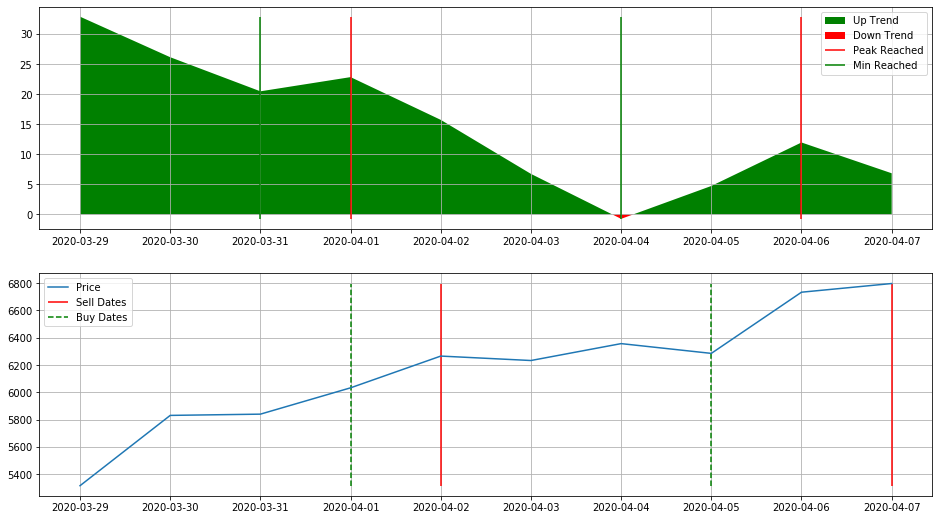

In [4]:
locs_and_grad = price_model(data)
evaluate_price_model(data, locs_and_grad=locs_and_grad, ticker=ticker, visualize=True)

## SUMMARY:
Look at the first graph. It has a maximum at the 2020-04-06, i.e. yesterday. However, the maximum is dependend on the price today, i.e. the current price since bitcoin is traded 24/7. The question is when this maximum will vanish. That means we should hold our position.
This will be evaluated in the following.

Firstly, we set up a new price series which we call "imag_data" and paste all values of the original data to this one.
If the market is currently closed, it is possible that today's value is not yet included in the data. In that case, we append today's value with "nan"

In [5]:
#check if there is a value of today:
today_value_avail = pd.Timestamp.today().normalize() in data.index
#ATTENTION: IF LAST ENTRY OF DATA IS NOT YESTERDAY (e.g. OVER WEEKENDS WHEN MARKETS ARE CLOSED), 
#ONE CAN GET AN INTERPOLATED VALUE FOR SELL PRICE IN THE MODEL DATAFRAME!
if today_value_avail:
    imag_data = pd.DataFrame.copy(data, deep=True)
    imag_new_day = imag_data.index[-1]
else:
    imag_new_day = pd.date_range(pd.Timestamp.today(), periods = 1, normalize=True)
    imag_days = data.index.append(imag_new_day)
    imag_data = pd.Series('NaN', index=imag_days)
    imag_data[data.index] = data.values

Now we have to independent price series

In [6]:
print('ORIGINAL DATA:\n', data.tail())
print('-'*20)
print('IMAGINARY DATA:\n', imag_data.tail())

ORIGINAL DATA:
 Date
2020-04-03    6232.120605
2020-04-04    6355.882812
2020-04-05    6284.361816
2020-04-06    6732.447754
2020-04-07    6796.007812
Name: Close, dtype: float64
--------------------
IMAGINARY DATA:
 Date
2020-04-03    6232.120605
2020-04-04    6355.882812
2020-04-05    6284.361816
2020-04-06    6732.447754
2020-04-07    6796.007812
Name: Close, dtype: float64


Secondly, we play with the last value of "imag_data" to see when the gradient of today=gradient of yesterday. Hence we have a break point --> time to sell/buy.

In [7]:
#create a price range with 50% deviation of the last one.
deviation = .5
start_value = (data.tail(1).values * (1 - deviation))
end_value = (data.tail(1).values * (1 + deviation))
step_size = end_value / start_value
rng = np.arange(start_value, end_value, step_size)

In [8]:
#start the algorithm
for imag_close in rng:
    imag_data[imag_new_day] = imag_close
    imag_locs_and_grad = price_model(imag_data)
    imag_locs = imag_locs_and_grad[0:2]
    imag_grad = imag_locs_and_grad[-1]
    if np.sign(np.diff(imag_grad)[-1]) > 0:
        print("Break Value found. Sell if today's value is expected to be less than {}!".format(imag_close))
        break
    else:
        #implement buy signal, but not here!
        pass
imag_data[imag_new_day] = rng[np.where(rng == imag_close)[0] - 1]

Break Value found. Sell if today's value is expected to be less than 6959.00390625!


We found a break value (logically). We paste the value for which we sell/buy into the "imag_data":

In [9]:
print('MODIFIED IMAGINARY DATA:\n', imag_data.tail())

MODIFIED IMAGINARY DATA:
 Date
2020-04-03    6232.120605
2020-04-04    6355.882812
2020-04-05    6284.361816
2020-04-06    6732.447754
2020-04-07    6956.003906
Name: Close, dtype: float64


Thirdly, evaluate the new, imag_data with our tools:

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                            ticker = IMAGINARY DATA                             |
|                             start date = 03/29/20                              |
|                              end date = 04/07/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: No tax paid. (win < 800)!
********************************************************************************
[SUMMARY]: Perfect Model --> Zero Bad Calls
[SUMMARY]:

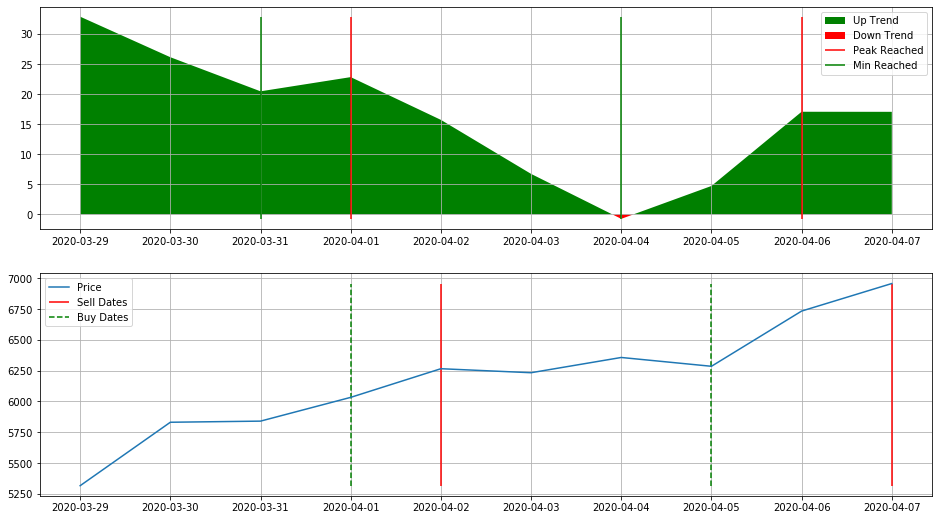

In [10]:
imag_locs_and_grad = price_model(imag_data)
evaluate_price_model(imag_data, locs_and_grad=imag_locs_and_grad, visualize=True, ticker='IMAGINARY DATA')

Finally, we see that in the first plot, the value doesn't change from the 2020-04-06 to 2020-04-07, that is our breaking point, i.e. time to sell.

What happens if today's value is above the breaking point? Let's see with a value that is 10% above our breaking value:

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = Unknown                                |
|                             start date = 03/29/20                              |
|                              end date = 04/07/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: There is currently an open position to be sold in the future.
[INFO]: No tax paid. (win < 800)!
[INFO]: Last entry of "Sell Dates" will be assigned equally as th

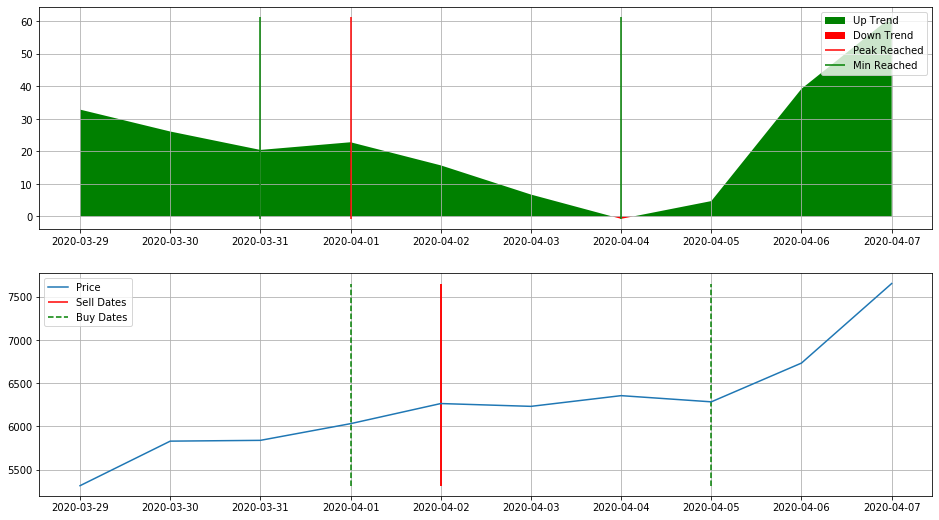

In [11]:
#temporarily store breaking_value:
breaking_value = imag_data.values[-1]
#asset imag_data to 10% above breaking value:
imag_data.values[-1] = breaking_value * 1.1
imag_locs_and_grad = price_model(imag_data)
evaluate_price_model(imag_data, locs_and_grad=imag_locs_and_grad, visualize=True)
#reset our original breaking value:
imag_data.values[-1] = breaking_value

As expected, the moment of rising prices is still here! Hence, we should hold our position.

# Final remarks

## --> This a very is simplified model for trading. One should always invest just as much money as one can afford to loose and do own studies in advance. 